In [1]:
import tensorflow as tf 
import os

Downloading the dataset from kaggle in google colab

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download fournierp/captcha-version-2-images
! unzip captcha-version-2-images.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 29% 5.00M/17.4M [00:00<00:00, 27.0MB/s]
100% 17.4M/17.4M [00:00<00:00, 69.3MB/s]
Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/

Creating Model

In [3]:
def create_model():


  X = tf.keras.layers.Input(shape=(50,200,1),batch_size=None,name="input_layer")

  conv_1 = tf.keras.layers.Conv2D(16,(3,3))(X)

  max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(32,(3,3))(max_pool_1)

  max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(32,(3,3))(max_pool_2)

  bn = tf.keras.layers.BatchNormalization()(conv_3)

  max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(3,3))(bn)

  flattened = tf.keras.layers.Flatten()(max_pool_3)

  outs = []

  for _ in range(5):
    dens1 = tf.keras.layers.Dense(64, activation='relu')(flattened)
    drop = tf.keras.layers.Dropout(0.5)(dens1)
    res = tf.keras.layers.Dense(19,activation='softmax')(drop)
    outs.append(res)

  model = tf.keras.Model(X, outs)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

  model.summary()

  return model

Preprocessing dataset

In [4]:
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18,'s':19}

In [5]:
def create_dataset():
  import cv2
  X = []
  y = []
  x = os.listdir('/content/samples')
  
  for i in range(len(x)):
    if x[i] == 'samples':
      continue
    y.append(x[i][0:5])
    X.append('/content/samples/'+x[i])
  
  y_indexed = []
  
  for i in range(len(y)):
    indexes = []
    for j in range(5):
      indexes.append([j,y[i][j]])
    y_indexed.append(indexes)
  
  for i in range(len(y_indexed)):
    for j in range(5):
      y_indexed[i][j][1] =  char_to_num[y_indexed[i][j][1]]

  import numpy as np
  
  x = []
  for i in range(len(X)):
    x.append(cv2.cvtColor(cv2.imread(X[i]),cv2.COLOR_BGR2GRAY).reshape(50, 200,1))
  x = np.array(x)
  y = np.array(y_indexed)

  return x , y[:,:,1]

In [6]:
model = create_model()
x , y = create_dataset()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 198, 16)  160         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 66, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 64, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [7]:
x.shape , y.shape

((1070, 50, 200, 1), (1070, 5))

In [8]:
x[0] , y[0]

(array([[[192],
         [192],
         [192],
         ...,
         [251],
         [251],
         [251]],
 
        [[192],
         [192],
         [192],
         ...,
         [251],
         [251],
         [251]],
 
        [[192],
         [192],
         [192],
         ...,
         [251],
         [251],
         [251]],
 
        ...,
 
        [[195],
         [195],
         [195],
         ...,
         [254],
         [254],
         [254]],
 
        [[195],
         [195],
         [195],
         ...,
         [254],
         [254],
         [254]],
 
        [[195],
         [195],
         [195],
         ...,
         [254],
         [254],
         [254]]], dtype=uint8), array([ 9, 18,  1,  8, 17]))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
model.fit(x=X_train,y=[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],validation_data=(X_test,\
                  [y_test[:,0],y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4]]),epochs=100)

Epoch 1/100
27/27 [==============================] - 33s 35ms/step - loss: 16.4692 - dense_1_loss: 3.3551 - dense_3_loss: 3.3411 - dense_5_loss: 3.1444 - dense_7_loss: 3.3390 - dense_9_loss: 3.2897 - dense_1_accuracy: 0.0713 - dense_3_accuracy: 0.0654 - dense_5_accuracy: 0.0654 - dense_7_accuracy: 0.0654 - dense_9_accuracy: 0.0607 - val_loss: 23.6531 - val_dense_1_loss: 4.0440 - val_dense_3_loss: 4.6998 - val_dense_5_loss: 4.0816 - val_dense_7_loss: 4.6025 - val_dense_9_loss: 6.2251 - val_dense_1_accuracy: 0.0514 - val_dense_3_accuracy: 0.0701 - val_dense_5_accuracy: 0.1168 - val_dense_7_accuracy: 0.0561 - val_dense_9_accuracy: 0.0561
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 14.6449 - dense_1_loss: 2.9358 - dense_3_loss: 2.9289 - dense_5_loss: 2.9041 - dense_7_loss: 2.9390 - dense_9_loss: 2.9371 - dense_1_accuracy: 0.0724 - dense_3_accuracy: 0.0643 - dense_5_accuracy: 0.0935 - dense_7_accuracy: 0.0654 - dense_9_accuracy: 0.0853 - val_loss: 16.7973 - val_

In [13]:
prediction = model.predict(X_test[0].reshape(1,50,200,1))
prediction

[array([[3.3467537e-10, 1.4380672e-11, 5.9642981e-18, 3.8256100e-12,
         4.1947840e-14, 1.3310801e-16, 7.4397198e-12, 2.1118422e-10,
         4.2996742e-08, 1.3574450e-08, 2.0357453e-07, 8.1916262e-12,
         4.1875624e-06, 2.3303153e-01, 2.3144178e-01, 5.3549606e-01,
         2.5774441e-05, 3.9290944e-07, 1.3444860e-09]], dtype=float32),
 array([[2.3958040e-07, 2.5578140e-04, 4.9976721e-09, 6.0705219e-07,
         1.7394460e-07, 4.1721307e-08, 1.9325278e-06, 1.1887046e-10,
         3.3423699e-02, 2.9197315e-04, 1.8725880e-06, 3.0504141e-10,
         9.6504807e-01, 4.5202939e-09, 1.6327180e-06, 9.3242509e-04,
         6.2264959e-08, 8.3679497e-06, 3.3175773e-05]], dtype=float32),
 array([[2.89479434e-03, 8.97787220e-04, 8.44769324e-11, 5.96220046e-03,
         1.70468528e-10, 4.80682909e-01, 1.43659207e-07, 2.33695840e-10,
         5.09539247e-01, 4.51566358e-08, 2.00911127e-05, 1.29532424e-07,
         1.50372841e-06, 5.69633793e-19, 1.01828375e-16, 4.39952574e-10,
         1.2

In [16]:
import numpy as np  
np.argmax(prediction[0])

15

In [17]:
char_to_num.items()

dict_items([('2', 0), ('3', 1), ('4', 2), ('5', 3), ('6', 4), ('7', 5), ('8', 6), ('b', 7), ('c', 8), ('d', 9), ('e', 10), ('f', 11), ('g', 12), ('m', 13), ('n', 14), ('p', 15), ('w', 16), ('x', 17), ('y', 18), ('s', 19)])

In [19]:
num_to_char = {value:key for key , value in char_to_num.items() }
num_to_char

{0: '2',
 1: '3',
 2: '4',
 3: '5',
 4: '6',
 5: '7',
 6: '8',
 7: 'b',
 8: 'c',
 9: 'd',
 10: 'e',
 11: 'f',
 12: 'g',
 13: 'm',
 14: 'n',
 15: 'p',
 16: 'w',
 17: 'x',
 18: 'y',
 19: 's'}

In [22]:
word = ""
for i in range(len(prediction)):
  word += num_to_char[np.argmax(prediction[i])]
word

'pgc5x'

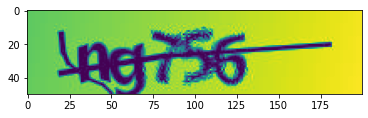

In [24]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0].reshape(50,200))

In [25]:
def predict(img):
  
  prediction = model.predict(img.reshape(1,50,200,1))
  word = ""
  for i in range(len(prediction)):
    word += num_to_char[np.argmax(prediction[i])]

  return word

predictied nny5e


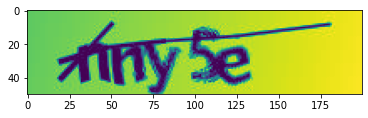

In [27]:
captcha =  predict(X_train[0])
plt.imshow(X_train[0].reshape(50,200))
print("predictied",captcha)

predictied 2p73f


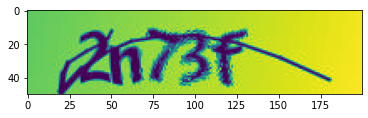

In [28]:
captcha =  predict(X_test[7])
plt.imshow(X_test[7].reshape(50,200))
print("predictied",captcha)

predictied mn6w6


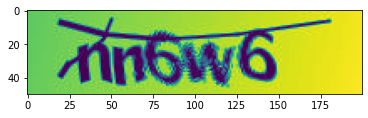

In [29]:
captcha =  predict(X_test[20])
plt.imshow(X_test[20].reshape(50,200))
print("predictied",captcha)

In [30]:
model.fit(x=X_train,y=[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],validation_data=(X_test,\
                  [y_test[:,0],y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4]]),epochs=100)

Epoch 1/100
27/27 [==============================] - 0s 13ms/step - loss: 1.1834 - dense_1_loss: 0.1547 - dense_3_loss: 0.1484 - dense_5_loss: 0.2725 - dense_7_loss: 0.3673 - dense_9_loss: 0.2406 - dense_1_accuracy: 0.9439 - dense_3_accuracy: 0.9486 - dense_5_accuracy: 0.9007 - dense_7_accuracy: 0.8551 - dense_9_accuracy: 0.9077 - val_loss: 2.9713 - val_dense_1_loss: 0.2448 - val_dense_3_loss: 0.4335 - val_dense_5_loss: 0.9414 - val_dense_7_loss: 0.8025 - val_dense_9_loss: 0.5491 - val_dense_1_accuracy: 0.9206 - val_dense_3_accuracy: 0.8645 - val_dense_5_accuracy: 0.7103 - val_dense_7_accuracy: 0.7757 - val_dense_9_accuracy: 0.8411
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 1.2150 - dense_1_loss: 0.1520 - dense_3_loss: 0.1427 - dense_5_loss: 0.2986 - dense_7_loss: 0.3403 - dense_9_loss: 0.2815 - dense_1_accuracy: 0.9498 - dense_3_accuracy: 0.9533 - dense_5_accuracy: 0.8914 - dense_7_accuracy: 0.8750 - dense_9_accuracy: 0.9030 - val_loss: 2.5530 - val_dens

In [31]:
model.fit(x=X_train,y=[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],validation_data=(X_test,\
                  [y_test[:,0],y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4]]),epochs=100)

Epoch 1/100
27/27 [==============================] - 0s 12ms/step - loss: 0.6651 - dense_1_loss: 0.0763 - dense_3_loss: 0.0695 - dense_5_loss: 0.1958 - dense_7_loss: 0.1893 - dense_9_loss: 0.1342 - dense_1_accuracy: 0.9708 - dense_3_accuracy: 0.9766 - dense_5_accuracy: 0.9252 - dense_7_accuracy: 0.9276 - dense_9_accuracy: 0.9579 - val_loss: 3.3422 - val_dense_1_loss: 0.1826 - val_dense_3_loss: 0.7451 - val_dense_5_loss: 0.9339 - val_dense_7_loss: 0.7549 - val_dense_9_loss: 0.7256 - val_dense_1_accuracy: 0.9299 - val_dense_3_accuracy: 0.8505 - val_dense_5_accuracy: 0.8271 - val_dense_7_accuracy: 0.8505 - val_dense_9_accuracy: 0.8271
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6454 - dense_1_loss: 0.0682 - dense_3_loss: 0.0735 - dense_5_loss: 0.1770 - dense_7_loss: 0.1775 - dense_9_loss: 0.1493 - dense_1_accuracy: 0.9661 - dense_3_accuracy: 0.9766 - dense_5_accuracy: 0.9264 - dense_7_accuracy: 0.9311 - dense_9_accuracy: 0.9439 - val_loss: 3.0672 - val_dens

In [32]:
model.fit(x=X_train,y=[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],validation_data=(X_test,\
                  [y_test[:,0],y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4]]),epochs=1000)

Epoch 1/1000
27/27 [==============================] - 0s 11ms/step - loss: 0.4094 - dense_1_loss: 0.0557 - dense_3_loss: 0.0604 - dense_5_loss: 0.0845 - dense_7_loss: 0.1067 - dense_9_loss: 0.1022 - dense_1_accuracy: 0.9766 - dense_3_accuracy: 0.9778 - dense_5_accuracy: 0.9661 - dense_7_accuracy: 0.9591 - dense_9_accuracy: 0.9591 - val_loss: 3.2100 - val_dense_1_loss: 0.0989 - val_dense_3_loss: 0.4957 - val_dense_5_loss: 0.9924 - val_dense_7_loss: 1.0374 - val_dense_9_loss: 0.5856 - val_dense_1_accuracy: 0.9720 - val_dense_3_accuracy: 0.8972 - val_dense_5_accuracy: 0.7710 - val_dense_7_accuracy: 0.8224 - val_dense_9_accuracy: 0.9065
Epoch 2/1000
27/27 [==============================] - 0s 10ms/step - loss: 0.4249 - dense_1_loss: 0.0584 - dense_3_loss: 0.0645 - dense_5_loss: 0.0932 - dense_7_loss: 0.1242 - dense_9_loss: 0.0847 - dense_1_accuracy: 0.9778 - dense_3_accuracy: 0.9755 - dense_5_accuracy: 0.9614 - dense_7_accuracy: 0.9568 - dense_9_accuracy: 0.9696 - val_loss: 3.3026 - val_de

KeyboardInterrupt: ignored

predictied 2n73f


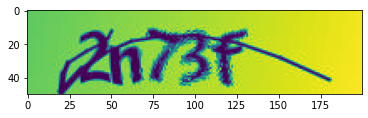

In [33]:
captcha =  predict(X_test[7])
plt.imshow(X_test[7].reshape(50,200))
print("predictied",captcha)

predictied nn6w6


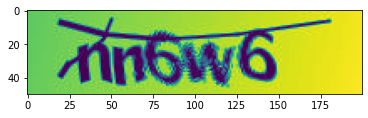

In [34]:
captcha =  predict(X_test[20])
plt.imshow(X_test[20].reshape(50,200))
print("predictied",captcha)

predictied ng756


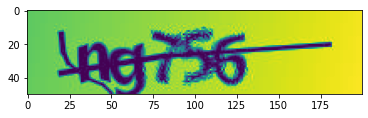

In [35]:
captcha = predict(X_test[0])
plt.imshow(X_test[0].reshape(50,200))
print("predictied",captcha)

In [37]:
model.save('/content')

INFO:tensorflow:Assets written to: /content/assets


In [38]:
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/model.h5")